In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import tensorflow.contrib.layers as layers
import os
from os.path import exists, join
from os import listdir
import urllib
import tarfile
from tensorflow.contrib.slim.nets import vgg as vgg_whole
import tensorflow.contrib.slim as slim

In [2]:
%matplotlib inline

# Transfer learning example
Transfer learning is a machine learning technique, where knowledge gain during training in one type of problem is used to train in other similar type of problem


In this notebook we gonna take existing cnn (VGG16), which has been trained to recognize 1000 classes of various objects. Now we going to retrain this network to solve unrelated problem.

Usualy there is two possible scenarios:
* retrain whole network
* remove few last layers, add new ones and train only them.

In [3]:
#Lets download VGG_16 model weights

dest_directory = './VGG_model'
DATA_URL = 'http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz'
if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
filename = DATA_URL.split('/')[-1]
filepath = join(dest_directory, filename)
if not exists(filepath):
    urllib.urlretrieve(DATA_URL, filepath)
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    
tarfile.open(filepath, 'r:gz').extractall(dest_directory)


model_file  = [i for i in os.listdir(dest_directory) if 'ckpt' in i][-1]
model_file = join(dest_directory, model_file)
print model_file


./VGG_model/vgg_16.ckpt


# VGG network
In this section we will define VGG network using tf.contrib.layers and tf.contrib.slim. Keep in mind that tensorflow is changing rapidly. In tf version 1.0 tf.contrib.slim was integrated to tf.layers and tf.contrib.layers.

Below you will se these new concepts:
* arg_scope - default parameters for layers that helps to keep model code clean and elegant.
* repeat - removes need of repetive definition of layers

# Repeat

We have code:
```python
net = slim.conv2d(net, 256, [3, 3], scope='conv3_1')
net = slim.conv2d(net, 256, [3, 3], scope='conv3_2')
net = slim.conv2d(net, 256, [3, 3], scope='conv3_3')
```
and instead we can use this construct for the same result. You can only **repeat** for layers with same parameters.
```python
net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
```

# Arg_scope

```python
def vgg_arg_scope(weight_decay=0.0005):
    """Defines the VGG arg scope.
      Args:
        weight_decay: The l2 regularization coefficient.
      Returns:
        An arg_scope.
      """
      
    with arg_scope(
        [layers.conv2d, layers_lib.fully_connected],
        activation_fn=nn_ops.relu,
        weights_regularizer=regularizers.l2_regularizer(weight_decay),
        biases_initializer=init_ops.zeros_initializer,
        trainable=False):
        with arg_scope([layers.conv2d], padding='SAME') as arg_sc:
            return arg_sc
```
# Actual VGG_16 network definition

```python
def vgg_16(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           spatial_squeeze=True,
           scope='vgg_16'):
    
    """
    Oxford Net VGG 16-Layers version D Example.

    Note: All the fully_connected layers have been transformed to conv2d layers.
        To use in classification mode, resize input to 224x224.

    Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    num_classes: number of predicted classes.
    is_training: whether or not the model is being trained.
    dropout_keep_prob: the probability that activations are kept in the dropout
      layers during training.
    spatial_squeeze: whether or not should squeeze the spatial dimensions of the
      outputs. Useful to remove unnecessary dimensions for classification.
    scope: Optional scope for the variables.

    Returns:
    the last op containing the log predictions and end_points dict.
    """
    with variable_scope.variable_scope(scope, 'vgg_16', [inputs]) as sc:
        end_points_collection = sc.original_name_scope + '_end_points'
        # Collect outputs for conv2d, fully_connected and max_pool2d.
        with arg_scope(
            [layers.conv2d, layers_lib.fully_connected, layers_lib.max_pool2d],
            outputs_collections=end_points_collection):
            net = layers_lib.repeat(
              inputs, 2, layers.conv2d, 64, [3, 3], scope='conv1')
            net = layers_lib.max_pool2d(net, [2, 2], scope='pool1')
            net = layers_lib.repeat(net, 2, layers.conv2d, 128, [3, 3], scope='conv2')
            net = layers_lib.max_pool2d(net, [2, 2], scope='pool2')
            net = layers_lib.repeat(net, 3, layers.conv2d, 256, [3, 3], scope='conv3')
            net = layers_lib.max_pool2d(net, [2, 2], scope='pool3')
            net = layers_lib.repeat(net, 3, layers.conv2d, 512, [3, 3], scope='conv4')
            net = layers_lib.max_pool2d(net, [2, 2], scope='pool4')
            net = layers_lib.repeat(net, 3, layers.conv2d, 512, [3, 3], scope='conv5')
            net = layers_lib.max_pool2d(net, [2, 2], scope='pool5')
            # Use conv2d instead of fully_connected layers.
            net = layers.conv2d(net, 4096, [7, 7], padding='VALID', scope='fc6')
            net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='dropout6')
            net = layers.conv2d(net, 4096, [1, 1], scope='fc7')
            net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='dropout7')
            net = layers.conv2d(net,
                                num_classes,
                                [1, 1],
                                activation_fn=None,
                                normalizer_fn=None,
                                scope='fc8',
                                trainable=True)
            # Convert end_points_collection into a end_point dict.
            end_points = utils.convert_collection_to_dict(end_points_collection)
            if spatial_squeeze:
                net = array_ops.squeeze(net, [1, 2], name='fc8/squeezed')
                end_points[sc.name + '/fc8'] = net
            return net, end_points
            
```

# Download dogs vs cats data

In [4]:
dest_directory = './VGG_data'
# For full version of data go to kaggle.com and look at competition Dogs vs. Cats 
DATA_URL = ' http://download.neurotechnology.com/pgGj5xn6Go1do35O/e6GTZ_KW9cwgTQVj/cats_vs_dogs.tar.gz'
if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
filename = DATA_URL.split('/')[-1]
filepath = join(dest_directory, filename)
if not exists(filepath):
    urllib.urlretrieve(DATA_URL, filepath)
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')

train_dir = join(dest_directory, 'train_split')
valid_dir = join(dest_directory, 'valid_split')

if not exists(train_dir) and not exists(valid_dir):
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)
# After extraction we will have train_split, valid_split

flist = listdir(train_dir)
dog = sum([1 for i in flist if 'dog' in i])
cat = sum([1 for i in flist if 'cat' in i])
print "We have {} train samples, dogs: {}  cats:{}".format(len(flist), dog, cat)

flist = listdir(valid_dir)
dog = sum([1 for i in flist if 'dog' in i])
cat = sum([1 for i in flist if 'cat' in i])

print "We have {} test samples, dogs: {}  cats:{}".format(len(flist), dog, cat)




We have 2250 train samples, dogs: 1147  cats:1103
We have 250 test samples, dogs: 129  cats:121


# Lets look how data looks like

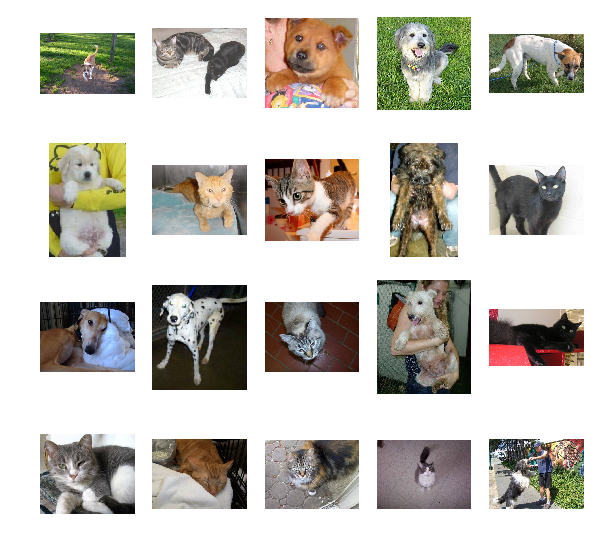

In [6]:
import skimage.io as io

#Lets look at few of images of train_dir 
flist = listdir(train_dir)

plt.figure(figsize=(2. * 3.5, 2.26 * 3))
plt.title("Face completion with multi-output estimators")
           
for i in range(20):
    img = io.imread(join(train_dir, flist[i]))
    sub = plt.subplot(4,5,i+1)
    sub.axis("off")
    sub.imshow(img, cmap=plt.cm.gray, interpolation="nearest")
plt.show()


# Let's nail it
We gonna do this step by step
* First explore how VGG network weights restoration works
* Then data reading using queues
* Training script

# Pretrained weights loading

In [7]:
# We gona restore all variables, and finetoone whole network.

train_images = tf.placeholder(tf.float32, [None, 224,224, 3], name="input")
is_training = tf.placeholder(tf.bool, [], name='is_training')

# Step 1: define model we are using model defined in tensorflow, not one we defined
with slim.arg_scope(vgg_whole.vgg_arg_scope()):
    logits, _ = vgg_whole.vgg_16(train_images, num_classes=2, is_training=is_training)
        
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())

    # Step 2: We gonna restore all variables except last layer and look at them
    variables_to_restore = [i for i in tf.model_variables() if not 'fc8' in i.op.name]    
    print "INFO: variables to restore"
    for i in variables_to_restore:
        print i.op.name, i.get_shape()
    
    # Step 3: Lets look at trainable variables:
    print "INFO: trainable variables before restore"
    for i in tf.trainable_variables():
        print i.op.name, i.get_shape(), tf.reduce_mean(i).eval()
    
    # Step 4: Restore variables
    saver_restore = tf.train.Saver(var_list=variables_to_restore)
    saver_restore.restore(sess, model_file)
    print "INFO: trainable variables after restore"
    for i in tf.trainable_variables():
        print i.op.name, i.get_shape(), tf.reduce_mean(i).eval()


INFO: variables to restore
vgg_16/conv1/conv1_1/weights (3, 3, 3, 64)
vgg_16/conv1/conv1_1/biases (64,)
vgg_16/conv1/conv1_2/weights (3, 3, 64, 64)
vgg_16/conv1/conv1_2/biases (64,)
vgg_16/conv2/conv2_1/weights (3, 3, 64, 128)
vgg_16/conv2/conv2_1/biases (128,)
vgg_16/conv2/conv2_2/weights (3, 3, 128, 128)
vgg_16/conv2/conv2_2/biases (128,)
vgg_16/conv3/conv3_1/weights (3, 3, 128, 256)
vgg_16/conv3/conv3_1/biases (256,)
vgg_16/conv3/conv3_2/weights (3, 3, 256, 256)
vgg_16/conv3/conv3_2/biases (256,)
vgg_16/conv3/conv3_3/weights (3, 3, 256, 256)
vgg_16/conv3/conv3_3/biases (256,)
vgg_16/conv4/conv4_1/weights (3, 3, 256, 512)
vgg_16/conv4/conv4_1/biases (512,)
vgg_16/conv4/conv4_2/weights (3, 3, 512, 512)
vgg_16/conv4/conv4_2/biases (512,)
vgg_16/conv4/conv4_3/weights (3, 3, 512, 512)
vgg_16/conv4/conv4_3/biases (512,)
vgg_16/conv5/conv5_1/weights (3, 3, 512, 512)
vgg_16/conv5/conv5_1/biases (512,)
vgg_16/conv5/conv5_2/weights (3, 3, 512, 512)
vgg_16/conv5/conv5_2/biases (512,)
vgg_16/co

# Data loading

In [7]:
# Do default VGG preprocessing of images:  https://github.com/tensorflow/models/tree/master/slim/preprocessing
import vgg_preprocessing as prep

In [11]:
# Step 1: write op to read and preprocess single file

def SingleFileReader(filename_queue, is_training=True, height=224, width=224):
    """Read single jpg file and do vgg preprocessing"""
    class CatsDogsRecord(object):
        pass
    result = CatsDogsRecord()    
    image_file = tf.read_file(filename_queue[0])
    decoded_image = tf.image.decode_jpeg(image_file, channels=3)
    result.image = prep.preprocess_image(decoded_image, height, width, is_training=is_training)
    result.label = tf.cast(filename_queue[1], tf.int32)
    return result

#Step 2: We write input data pipeline code
def train_inputs(batch_size=64, is_training=True, num_epochs=1, num_threads=2):
    """Construct a queued batch of images and labels."""
    src_dir = train_dir if is_training else valid_dir
    print "INFO: Src_dir: ", src_dir
    
    files = []
    labels = []
    for i in listdir(src_dir):
        files.append(join(src_dir, i))
        labels.append(1 if 'dog' in i else 0)
    
    img = tf.convert_to_tensor(files, dtype=tf.string)
    lab = tf.convert_to_tensor(labels, dtype=tf.int32)
    
    filename_queue = tf.train.slice_input_producer([img, lab],
                                                   num_epochs=num_epochs,
                                                   seed=1234,
                                                   capacity=500,
                                                   shuffle=is_training)
    
    read_input = SingleFileReader(filename_queue, is_training=is_training)
    images_batch, label_batch = tf.train.batch([read_input.image, read_input.label],
                                         batch_size=batch_size,
                                         capacity=1000,
                                         num_threads=1)
    return images_batch, label_batch

#Step 3: Lets test our data pipeline

# images, labels = train_inputs(is_training=False)
# gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(tf.local_variables_initializer())
    
#     coord = tf.train.Coordinator()
#     tf.train.start_queue_runners(sess=sess, coord=coord)
#     img, l = sess.run([images, labels])
#     coord.request_stop()
#     print "INFO: batch shape: ", img.shape
#     plt.figure(figsize=(2. * 4, 2.26 * 4))
#     plt.title("Preprocessed images")
#     img = img.astype(np.uint8)
#     print img.shape, np.min(img), np.max(img), img.dtype, np.mean(img)
#     for i in range(20):
#         sub = plt.subplot(4,5,i+1)
#         sub.axis("off")
#         sub.imshow(img[i])
#     plt.show()
        


# Ok lets assemble everything

In [9]:
tf.reset_default_graph()

LEARNING_RATE = 0.001
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

# Step 1: get data
train_images, train_labels = train_inputs(batch_size=32, is_training=True, num_epochs=1)

# Step 2: define model we are using model defined in tensorflow, not one we defined
with slim.arg_scope(vgg_whole.vgg_arg_scope()):
    logits, _ = vgg_whole.vgg_16(train_images, num_classes=2, is_training=True)
    
# Step 3: We gonna restore all variables except last layer and look at them
    variables_to_restore = [i for i in tf.trainable_variables() if not 'fc8' in i.op.name]    
    
#Step 4: define savers
saver_restore = tf.train.Saver(var_list=variables_to_restore)
saver_train = tf.train.Saver(var_list=tf.trainable_variables())

#Step 5: define loss
with tf.name_scope('loss'):
    #We use sparse softmax cross entropy because our labels is 0 - for cat and 1 for dog (not one hotted)
    tf.losses.sparse_softmax_cross_entropy(train_labels, logits)
    #VGG use weight decay for regularization
    loss = tf.losses.get_total_loss(add_regularization_losses=True)

    
# Step 6: define training op
# using gradient descent with learning rate of LEARNING_RATE to minimize cost
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss, 
                                        global_step=global_step)

# Step 7: We create dir where to store checkpoint files
save_dir = './VGG_transfer/'
if not exists(save_dir):
    os.mkdir(save_dir)
    
# Step 8 Metrics
#We want to check not only training loss, but also training accuracy
predictions = tf.to_int32(tf.argmax(logits, axis=1, name='classes_tensor'))
with tf.name_scope('metrics'):    
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        "acc": slim.metrics.streaming_accuracy(predictions, train_labels),
        "loss": slim.metrics.streaming_mean(loss),
        })

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
#Step 9: Start data feed 
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess=sess, coord=coord)
    
    #Step 10 if we have saved checkpoint restore from it
    ckpt = tf.train.get_checkpoint_state(save_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print "INFO: restoring model: ", ckpt.model_checkpoint_path
        saver_train.restore(sess, ckpt.model_checkpoint_path)
    else:
        print "INFO: restoring model: ", model_file
        saver_restore.restore(sess, model_file)
    
    print "INFO: loading done"
    st = time.time()
        
    try:
        step = 0
        while not coord.should_stop():
            sess.run(fetches = [optimizer, names_to_updates.values()])

            #We monitor training after every 10 batches
            if step % 10 == 0:
                src_str = "Iteration: {} ".format(step)
                metric_values = sess.run(names_to_values.values())
                for metric, value in zip(names_to_values.keys(), metric_values):
                    src_str += 'metric: {} value: {} '.format(metric, value)
                print src_str

            step+=1
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
        print "Training took {}s, processed {}b".format(time.time()-st, step) 
    finally:
        coord.request_stop()
    saver_train.save(sess, '%s/model'%save_dir, global_step=step)
        
        
    
    
    

INFO: restoring model:  ./VGG_transfer/model-0
INFO: loading done
Iteration: 0 metric: acc value: 0.46875 metric: loss value: 1.98727202415 
Iteration: 10 metric: acc value: 0.772727251053 metric: loss value: 1.21361732483 
Iteration: 20 metric: acc value: 0.819940447807 metric: loss value: 1.06655466557 
Iteration: 30 metric: acc value: 0.84576612711 metric: loss value: 1.00102937222 
Iteration: 40 metric: acc value: 0.864329278469 metric: loss value: 0.962110221386 
Iteration: 50 metric: acc value: 0.866421580315 metric: loss value: 0.940007448196 
Iteration: 60 metric: acc value: 0.872950792313 metric: loss value: 0.915940761566 
Done training -- epoch limit reached
Training took 82.8994951248s, processed Tensor("global_step/read:0", shape=(), dtype=int32)b


# Lets test our model


In [12]:
tf.reset_default_graph()


# Step 1: get data
train_images, train_labels = train_inputs(batch_size=32, is_training=False, num_epochs=1)

# Step 2: define model we are using model defined in tensorflow, not one we defined
with slim.arg_scope(vgg_whole.vgg_arg_scope()):
    logits, _ = vgg_whole.vgg_16(train_images, num_classes=2, is_training=False)

#Step 5: define loss
with tf.name_scope('loss'):
    #We use sparse softmax cross entropy because our labels is 0 - for cat and 1 for dog (not one hotted)
    tf.losses.sparse_softmax_cross_entropy(train_labels, logits)
    #VGG use weight decay for regularization
    loss = tf.losses.get_total_loss(add_regularization_losses=True)

# Step 6: checkpoint dir
save_dir = './VGG_transfer/'

# Step 7: saver to restore model
saver_train = tf.train.Saver(var_list=tf.trainable_variables())

# Step 8 Metrics
#We want to check not only training loss, but also training accuracy
predictions = tf.to_int32(tf.argmax(logits, axis=1, name='classes_tensor'))
with tf.name_scope('metrics'):    
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        "acc": slim.metrics.streaming_accuracy(predictions, train_labels),
        "loss": slim.metrics.streaming_mean(loss),
        })

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
#Step 9: Start data feed 
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess=sess, coord=coord)
    
    #Step 10 if we have saved checkpoint restore from it
    ckpt = tf.train.get_checkpoint_state(save_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print "INFO: restoring model: ", ckpt.model_checkpoint_path
        saver_train.restore(sess, ckpt.model_checkpoint_path)
    
    print "INFO: loading done"
    st = time.time()
        
    try:
        step = 0
        while not coord.should_stop():
            #We just want metrics
            sess.run(fetches = [names_to_updates.values()])
            step+=1
    except tf.errors.OutOfRangeError:
        print "Done Testing"
        print "Testing took {}s, processed {}b".format(time.time()-st, step)
        metric_values = sess.run(names_to_values.values())
        src_str = ''
        for metric, value in zip(names_to_values.keys(), metric_values):
            src_str += 'metric: {} value: {} '.format(metric, value)
        print src_str
    finally:
        coord.request_stop()
    
        

INFO: Src_dir:  ./VGG_data/valid_split
INFO: restoring model:  ./VGG_transfer/model-70
INFO: loading done
Done Testing
Testing took 2.9357790947s, processed 7b
metric: acc value: 0.859375 metric: loss value: 0.566088080406 
